In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load existing dataset

In [2]:
# each tract's census info, along with all years' cum store months
df_final = pd.read_csv('data_for_DID.csv')

# matching info
matched_df_cleaned = pd.read_csv('matched_tracts_cleaned.csv')

# tract info with dispensary_status and match_id
dispensaries_updated = pd.read_csv('tract_status.csv')

## Get the growth rate

In [3]:
df_final.columns

Index(['Unnamed: 0', 'tract', 'year', 'rec', 'med', 'dispensary_status',
       'match_id', 'population', 'income', 'house_value', 'rent',
       'unemployment', 'poverty'],
      dtype='object')

In [4]:
df_to_use = df_final[['tract', 'year', 'rec', 'med', 'population', 'income', 'house_value', 'rent', 'unemployment', 'poverty']]

#### Divide the control and intervention groups

In [5]:
group_0 = dispensaries_updated[dispensaries_updated['dispensary_status']==0]
group_1 = dispensaries_updated[dispensaries_updated['dispensary_status']==1]

group_0_tracts = list(group_0.tract)
group_1_tracts = list(group_1.tract)

df_to_use_0 = df_to_use.loc[df_to_use ['tract'].isin(group_0_tracts)]
df_to_use_1 = df_to_use.loc[df_to_use ['tract'].isin(group_1_tracts)]


#### Functions for getting the growth rate

In [6]:

"""
    Given outcome variable, tract, and ralative dataframe, return growth rate dataframe
"""
def growth_rate_per_year (outcome, tract, df):
    
    curr_df = df[df['tract']==tract]
    outcome_change = curr_df[outcome].diff().dropna().values[:7]
    outcome_base = curr_df[outcome][:7].values
    
    data = {'Year': [1, 2, 3, 4, 5, 6, 7],
        'change_next_year': outcome_change,
         'base_curr_year': outcome_base}
    #print(data)
    new_df = pd.DataFrame(data)
    
    new_df['growth_rate'] = new_df['change_next_year']/new_df['base_curr_year']
    new_df['tract'] = tract
    
    return new_df


"""
    Given outcome variable, return growth rate dataframe, containing all tracts
"""

def get_growth_rate_df(outcome):
    res_df = []

    for each_group in [group_0_tracts, group_1_tracts]:

        df = df_to_use.loc[df_to_use ['tract'].isin(each_group)]
        growth_rate_df = []
        for each_tract in each_group:
            growth_rate_df.append(growth_rate_per_year (outcome, each_tract, df))

        res_df.append(pd.concat(growth_rate_df))
    
    return res_df

"""
    Given growth rate dataframes of both groups, return a dictionary containing all growth rates info
"""
def get_avg_growth_dict(growth_rate_0, growth_rate_1):
    
    res_dict = {}
    mean_group_0 = growth_rate_0.groupby('tract')['growth_rate'].agg(['mean'])
    mean_group_1 = growth_rate_1.groupby('tract')['growth_rate'].agg(['mean'])
    mean_group_1.reset_index(level=0, inplace=True)
    mean_group_0.reset_index(level=0, inplace=True)
    
    for each_tract in list(mean_group_0.tract):
        res_dict[each_tract] = mean_group_0[mean_group_0['tract']==each_tract]['mean'].values[0]
    
    for each_tract in list(mean_group_1.tract):
        res_dict[each_tract] = mean_group_1[mean_group_1['tract']==each_tract]['mean'].values[0]
        
    return res_dict

#### Get the growth rate dictionary for each outcome variable

In [7]:
# income
growth_rate_income = get_growth_rate_df('income')
growth_rate_income_0 = growth_rate_income[0]
growth_rate_income_1 = growth_rate_income[1]
income_avg_growth_dict = get_avg_growth_dict(growth_rate_income_0, growth_rate_income_1)

# population
growth_rate_population = get_growth_rate_df('population')
growth_rate_population_0 = growth_rate_population[0]
growth_rate_population_1 = growth_rate_population[1]
population_avg_growth_dict = get_avg_growth_dict(growth_rate_population_0, growth_rate_population_1)

# house value
growth_rate_housevalue = get_growth_rate_df('house_value')
growth_rate_housevalue_0 = growth_rate_housevalue[0]
growth_rate_housevalue_1 = growth_rate_housevalue[1]
housevalue_avg_growth_dict = get_avg_growth_dict(growth_rate_housevalue_0, growth_rate_housevalue_1)

# rent
growth_rate_rent = get_growth_rate_df('rent')
growth_rate_rent_0 = growth_rate_rent[0]
growth_rate_rent_1 = growth_rate_rent[1]
rent_avg_growth_dict = get_avg_growth_dict(growth_rate_rent_0, growth_rate_rent_1)

# unemployment
growth_rate_unemployment = get_growth_rate_df('unemployment')
growth_rate_unemployment_0 = growth_rate_unemployment[0]
growth_rate_unemployment_1 = growth_rate_unemployment[1]
unemployment_avg_growth_dict = get_avg_growth_dict(growth_rate_unemployment_0, growth_rate_unemployment_1)

# poverty
growth_rate_poverty = get_growth_rate_df('poverty')
growth_rate_poverty_0 = growth_rate_poverty[0]
growth_rate_poverty_1 = growth_rate_poverty[1]
poverty_avg_growth_dict = get_avg_growth_dict(growth_rate_poverty_0, growth_rate_poverty_1)

#### Create another dictionary for tracking growth rates of all outcome variables

In [8]:
avg_growth_dict_all_dim = {}
avg_growth_dict_all_dim['income'] = income_avg_growth_dict
avg_growth_dict_all_dim['population'] = population_avg_growth_dict
avg_growth_dict_all_dim['housevalue'] = housevalue_avg_growth_dict
avg_growth_dict_all_dim['rent'] = rent_avg_growth_dict
avg_growth_dict_all_dim['unemployment'] = unemployment_avg_growth_dict
avg_growth_dict_all_dim['poverty'] = poverty_avg_growth_dict

#### Get the differences between control and intervention groups 

In [9]:
def get_tract_mean(dim, dict_all_dim, tract):
    
    return dict_all_dim[dim][tract]


In [12]:
def get_min_max(vals):
    
    Q1 = vals.quantile(0.25)
    Q3 = vals.quantile(0.75)
    IQR = Q3 - Q1
    Lower = Q1 - (1.5 * IQR)
    Upper = Q3 + (1.5 * IQR)
    
    return Lower, Upper

In [39]:
df_all = []
for each_dim in ['income', 'population', 'housevalue', 'rent', 'unemployment', 'poverty']:

    # get mean and difference
    mean_cmp_df = matched_df_cleaned[matched_df_cleaned['dispensary_status']==0].reset_index(drop=True)
    mean_cmp_df['tract0_mean'] = mean_cmp_df['tract'].apply(lambda x: get_tract_mean(each_dim, avg_growth_dict_all_dim, x))
    mean_cmp_df['tract1_mean'] = mean_cmp_df['matched_tract'].apply(lambda x: get_tract_mean(each_dim, avg_growth_dict_all_dim, x))
    mean_cmp_df['difference'] = mean_cmp_df['tract1_mean'] - mean_cmp_df['tract0_mean']
    
    """
    print('Mean', mean_cmp_df['difference'].mean())
    print('Min', mean_cmp_df['difference'].min())
    print('Max', mean_cmp_df['difference'].max())
    """
    
    df_all.append(mean_cmp_df)
    

In [69]:
def get_text_pos(axs):
    ymin, ymax = axs.get_ylim()
    xmin, xmax = axs.get_xlim()
    text_pos_y = 8/10 * ymax
    text_pos_x = 1/50 * xmax
    
    return text_pos_y, text_pos_x

#### Plot the distribution of all six outcomes in a single graph

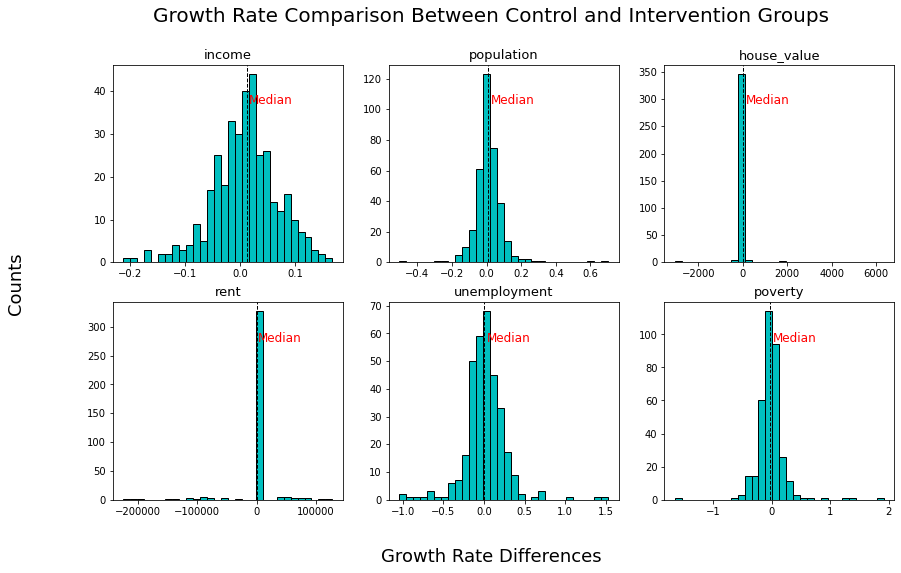

In [74]:
#figure(figsize=(8, 6), dpi=80)
outcomes = ['income', 'population', 'house_value', 'rent', 'unemployment', 'poverty']
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(14, 8, forward=True)

#add title
fig.suptitle('Growth Rate Comparison Between Control and Intervention Groups', size=20)
fig.supxlabel('Growth Rate Differences', size=18)
fig.supylabel('Counts', size=18)

#add data to plots
axs[0, 0].hist(df_all[0]['difference'], color='c', edgecolor='black', bins=30)
axs[0, 0].axvline(df_all[0]['difference'].median(), color='k', linestyle='dashed', linewidth=1)
axs[0, 0].set_title(outcomes[0], fontsize=13, loc='center')
text_pos_y, text_pos_x = get_text_pos(axs[0, 0])
axs[0, 0].text(df_all[0]['difference'].median()+text_pos_x, text_pos_y, 'Median', fontsize = 12,color = 'red')

axs[0, 1].hist(df_all[1]['difference'], color='c', edgecolor='black', bins=30)
axs[0, 1].axvline(df_all[1]['difference'].median(), color='k', linestyle='dashed', linewidth=1)
axs[0, 1].set_title(outcomes[1], fontsize=13, loc='center')
text_pos_y, text_pos_x = get_text_pos(axs[0, 1])
axs[0, 1].text(df_all[1]['difference'].median()+text_pos_x, text_pos_y, 'Median', fontsize = 12,color = 'red')

axs[0, 2].hist(df_all[2]['difference'], color='c', edgecolor='black', bins=30)
axs[0, 2].set_title(outcomes[2], fontsize=13, loc='center')
axs[0, 2].axvline(df_all[2]['difference'].median(), color='k', linestyle='dashed', linewidth=1)
axs[0, 2].set_title(outcomes[2], fontsize=13, loc='center')
text_pos_y, text_pos_x = get_text_pos(axs[0, 2])
axs[0, 2].text(df_all[2]['difference'].median()+text_pos_x, text_pos_y, 'Median', fontsize = 12,color = 'red')

axs[1, 0].hist(df_all[3]['difference'], color='c', edgecolor='black', bins=30)
axs[1, 0].set_title(outcomes[3], fontsize=13, loc='center')
axs[1, 0].axvline(df_all[3]['difference'].median(), color='k', linestyle='dashed', linewidth=1)
axs[1, 0].set_title(outcomes[3], fontsize=13, loc='center')
text_pos_y, text_pos_x = get_text_pos(axs[1, 0])
axs[1, 0].text(df_all[3]['difference'].median()+text_pos_x, text_pos_y, 'Median', fontsize = 12,color = 'red')

axs[1, 1].hist(df_all[4]['difference'], color='c', edgecolor='black', bins=30)
axs[1, 1].set_title(outcomes[4], fontsize=13, loc='center')
axs[1, 1].axvline(df_all[4]['difference'].median(), color='k', linestyle='dashed', linewidth=1)
axs[1, 1].set_title(outcomes[4], fontsize=13, loc='center')
text_pos_y, text_pos_x = get_text_pos(axs[1, 1])
axs[1, 1].text(df_all[4]['difference'].median()+text_pos_x, text_pos_y, 'Median', fontsize = 12,color = 'red')


axs[1, 2].hist(df_all[5]['difference'], color='c', edgecolor='black', bins=30)
axs[1, 2].set_title(outcomes[5], fontsize=13, loc='center')
axs[1, 2].axvline(df_all[5]['difference'].median(), color='k', linestyle='dashed', linewidth=1)
axs[1, 2].set_title(outcomes[5], fontsize=13, loc='center')
text_pos_y, text_pos_x = get_text_pos(axs[1, 2])
axs[1, 2].text(df_all[5]['difference'].median()+text_pos_x, text_pos_y, 'Median', fontsize = 12,color = 'red')


plt.savefig('Growth Rate Comparison.png', facecolor ="white")
plt.show()